C:\Users\M97947\AppData\Local\Temp\ipykernel_8348\2618431288.py:52: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False, infer_datetime_format=True)


Warnung: fehlen im Datensatz und werden ignoriert: ['Aussentemp_degCt']
Datengrößen – Gesamt: 12766, Train: 10212, Test (Holdout): 2554

Baseline (Naive Persistence) – Scores:
BL  (Train) MAE:  7.3336
BL  (Train) RMSE: 9.6404
BL  (Train) MAPE: 105.80%
BL  (Train) R²:   0.8844
BL  (Test)  MAE:  6.9935
BL  (Test)  RMSE: 8.9315
BL  (Test)  MAPE: 53.49%
BL  (Test)  R²:   0.9145
Fold 1 abgeschlossen.
Fold 2 abgeschlossen.
Fold 3 abgeschlossen.
Fold 4 abgeschlossen.
Fold 5 abgeschlossen.

Cross-Validation Scores (Trainzeitraum, OOF):
CV  MAE:  11.9483
CV  RMSE: 19.1961
CV  MAPE: 150.57%
CV  R²:   0.5416

Holdout Scores (zukunftsnaher Test):
TST MAE:  6.9196
TST RMSE: 8.8993
TST MAPE: 55.56%
TST R²:   0.9151

Verbesserung ggü. Baseline (Holdout):
Δ MAE:  +1.06%
Δ RMSE: +0.36%
Δ MAPE: -3.87%
Δ R²:   +0.0006

Top-15 Feature-Importances (Permutation, Holdout):
P_MW_lag1                1.239705
Windgeschw_mps           0.019657
P_MW_lag4                0.007989
Globale_Strahlung_Wm2    0.001647
h

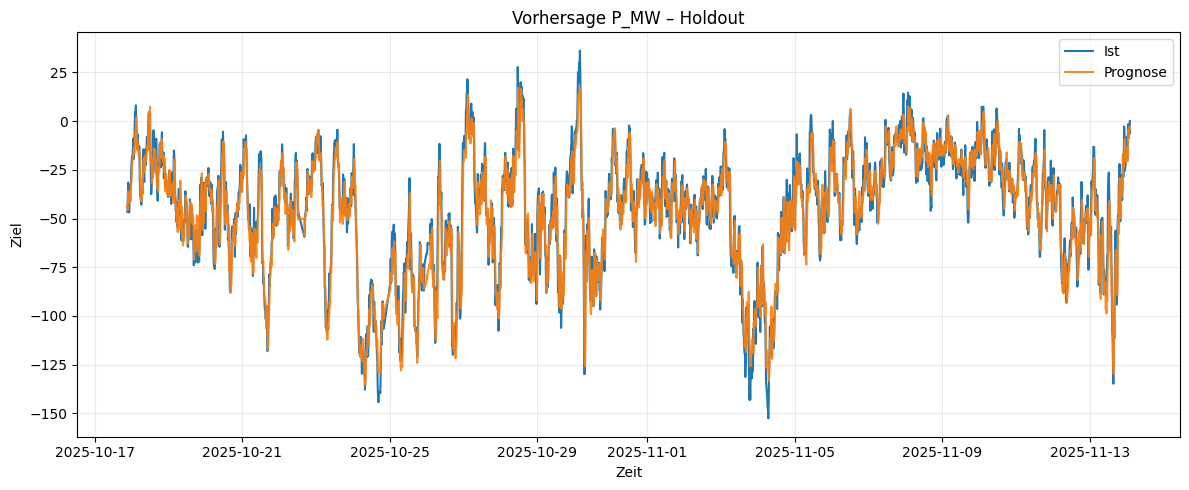


=== Zusammenfassung ===
CV  -> MAE: 11.9483 | RMSE: 19.1961 | MAPE: 150.57% | R²: 0.5416
TST -> MAE: 6.9196 | RMSE: 8.8993 | MAPE: 55.56% | R²: 0.9151
BL  -> MAE: 6.9935 | RMSE: 8.9315 | MAPE: 53.49% | R²: 0.9145


In [2]:
# -*- coding: utf-8 -*-
# Minimal-Setup: pip install pandas numpy scikit-learn matplotlib
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

# ======= USER-INPUT =======
CSV_PATH = r"C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code\fca_leistungsbaender\exploratory\handling_graph\out\nodes\SHUW_E24.csv"  # <--- Pfad zu deiner CSV
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]  
RAW_FEATURES = ["Windgeschw_mps","Globale_Strahlung_Wm2","Aussentemp_degCt"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h
# Rolling-Window-Längen (in 15-min-Schritten)
ROLL_WINDOWS = {
    "Windgeschw_Datapoint": [4, 12, 24],              # 1h, 3h, 6h
    "Globale_Strahlung_Datapoint": [4, 12, 24],       # 1h, 3h, 6h
    # Temperatur eher träge – hier optional, kann man hinzufügen, wenn sinnvoll
}
# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# ==========================

def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    # Zielspalte finden
    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")
    # Timestamp parsen & sortieren
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False, infer_datetime_format=True)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col

def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df

def add_fourier_features(df, period_steps, K, prefix="day"):
    # Index innerhalb der Periode (0..period_steps-1)
    # Nutzt den Abstand in Schritten à 15min relativ zum Start
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df

def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df

def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"]  = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"]  = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"]  = df[col].rolling(window=w, min_periods=w).max()
    return df

def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE kompatibel mit älteren sklearn-Versionen:
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", color="#1f77b4", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose", color="#ff7f0e", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Ziel")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

def main():
    df, target_col = load_data(CSV_PATH)

    # Basale Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    # Nur vorhandene Rohfeatures nutzen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    # Rolling-Features
    df = add_rolling_features(df, ROLL_WINDOWS)

    # Autoregressive Lags
    df = add_target_lags(df, target_col, TARGET_LAGS)

    # Liste aller Features
    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]
    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    # Drop NaNs, die durch Lags/Rollings entstehen
    df_model = df.dropna(subset=X_cols + [target_col]).copy()

    # Split in Train/Holdout
    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model[target_col]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")

    # ===== Baseline (Naive: y_hat_t = y_{t-1}) =====
    # Hinweis: Baseline muss an die gleiche Drop-NaN-Logik angepasst sein.
    y_train_baseline = df_model[f"{target_col}_lag1"].iloc[:split_idx].values
    y_test_baseline  = df_model[f"{target_col}_lag1"].iloc[split_idx:].values
    print("\nBaseline (Naive Persistence) – Scores:")
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== Modell + CV =====
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    cv_preds = np.zeros_like(y_train, dtype=float)
    model = HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.06,
        max_iter=700,
        max_depth=None,
        min_samples_leaf=20,
        l2_regularization=0.0,
        random_state=RANDOM_STATE
    )

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        mdl = model
        mdl.fit(X_tr, y_tr)
        cv_preds[val_idx] = mdl.predict(X_val)
        print(f"Fold {fold} abgeschlossen.")

    print("\nCross-Validation Scores (Trainzeitraum, OOF):")
    cv_scores = evaluate(y_train, cv_preds, prefix="CV  ")

    # ===== Final Fit + Holdout =====
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    print("\nHoldout Scores (zukunftsnaher Test):")
    test_scores = evaluate(y_test, y_pred_test, prefix="TST ")

    # Relativer Gewinn ggü. Baseline
    def rel_gain(metric):
        return 100.0 * (bl_scores[metric] - test_scores[metric]) / max(1e-9, bl_scores[metric])
    print("\nVerbesserung ggü. Baseline (Holdout):")
    print(f"Δ MAE:  {rel_gain('MAE'):+.2f}%")
    print(f"Δ RMSE: {rel_gain('RMSE'):+.2f}%")
    print(f"Δ MAPE: {rel_gain('MAPE'):+.2f}%")
    print(f"Δ R²:   {(test_scores['R2'] - bl_scores['R2']):+.4f}")

    # ===== Feature-Importance (Permutation) =====
    try:
        pi = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE)
        importances = pd.Series(pi.importances_mean, index=X_cols).sort_values(ascending=False)
        print("\nTop-15 Feature-Importances (Permutation, Holdout):")
        print(importances.head(15).to_string())
    except Exception as e:
        print(f"Permutation Importance übersprungen: {e}")

    # ===== Plot =====
    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, y_pred_test, title=f"Vorhersage {target_col} – Holdout")

    # Zusammenfassung
    print("\n=== Zusammenfassung ===")
    print(f"CV  -> MAE: {cv_scores['MAE']:.4f} | RMSE: {cv_scores['RMSE']:.4f} | MAPE: {cv_scores['MAPE']:.2f}% | R²: {cv_scores['R2']:.4f}")
    print(f"TST -> MAE: {test_scores['MAE']:.4f} | RMSE: {test_scores['RMSE']:.4f} | MAPE: {test_scores['MAPE']:.2f}% | R²: {test_scores['R2']:.4f}")
    print(f"BL  -> MAE: {bl_scores['MAE']:.4f} | RMSE: {bl_scores['RMSE']:.4f} | MAPE: {bl_scores['MAPE']:.2f}% | R²: {bl_scores['R2']:.4f}")

if __name__ == "__main__":
    main()
